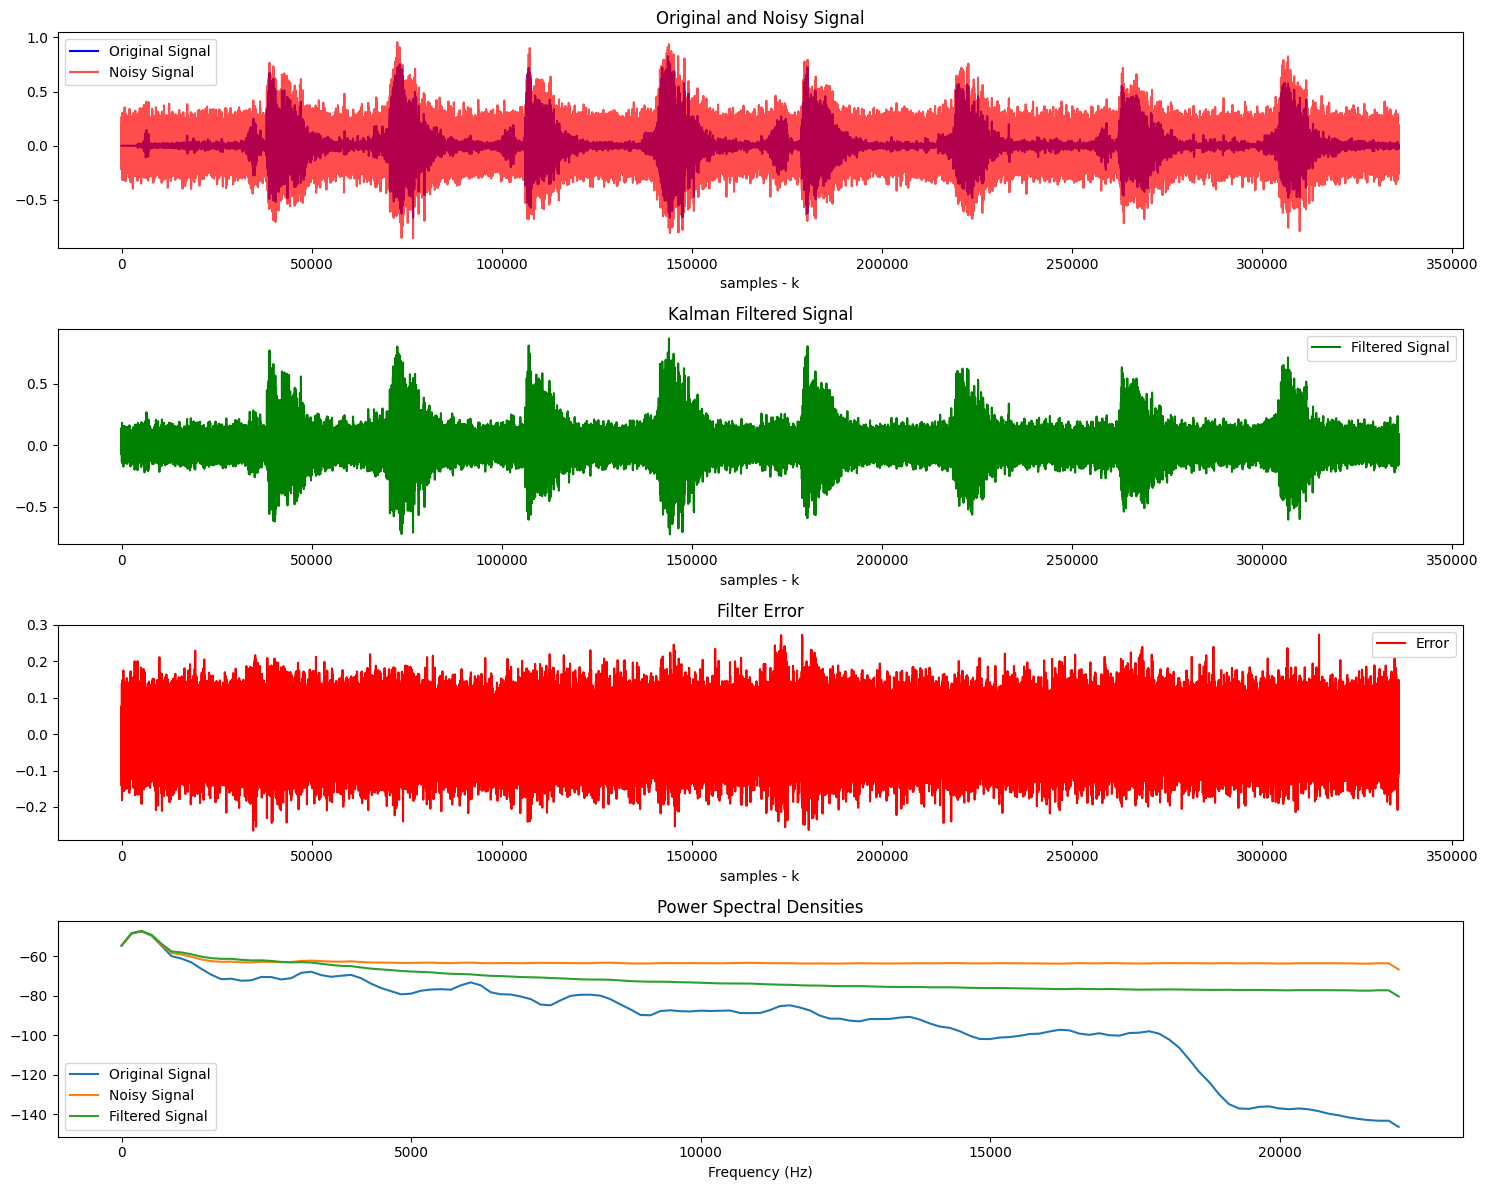

Time-domain MSE: 0.0031145180148064943
Frequency-domain MSE: 8.462180780909497e-14
Elapsed time is: 9.502384424209595 seconds.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import welch
import time

# Record the start time
start_time = time.time()

# Load the speech signal
file_path = "mono.wav"  # Replace with the actual path to your audio file
signal, sr = librosa.load(file_path, sr=None, mono=True)

# Create AWGN noise
noise = 0.1 * np.random.normal(size=len(signal))

# Mix the signal with noise
noisy_signal = signal + noise

# Define Kalman filter parameters
dt = 1.0  # Time step
A = np.array([[1, dt],
              [0, 1]])  # State transition matrix (constant velocity model)
H = np.array([[1, 0]])  # Measurement matrix (measuring position)

# Process and measurement noise covariance matrices
Q = 0.01 * np.eye(2)  # Process noise covariance
R = np.array([[1]])  # Measurement noise covariance

# Initial state and covariance
x_hat = np.array([0, 0])  # Initial state [position, velocity]
P = np.eye(2)  # Initial covariance matrix

# Number of time steps
num_steps = len(signal)

# Kalman filter loop
filtered_states = np.zeros((num_steps, 2))

for k in range(num_steps):
    # Prediction step
    x_hat_minus = A @ x_hat
    P_minus = A @ P @ A.T + Q

    # Update step
    K = P_minus @ H.T @ np.linalg.inv(H @ P_minus @ H.T + R)
    x_hat = x_hat_minus + K @ (noisy_signal[k] - H @ x_hat_minus)
    P = (np.eye(2) - K @ H) @ P_minus

    # Save filtered state
    filtered_states[k, :] = x_hat

# Calculate time-domain MSE
mse_time_domain = np.mean((signal - filtered_states[:, 0])**2)

# Calculate frequency-domain MSE using Blackman-Tukey method
frequencies, psd_original = welch(signal, fs=sr, nperseg=256, window='blackman')
frequencies, psd_noisy = welch(noisy_signal, fs=sr, nperseg=256, window='blackman')
frequencies, psd_filtered = welch(filtered_states[:, 0], fs=sr, nperseg=256, window='blackman')

mse_freq_domain = np.mean((psd_original - psd_filtered)**2)

# Plot the results
plt.figure(figsize=(15, 12))
plt.subplot(411); plt.title("Original and Noisy Signal"); plt.xlabel("samples - k")
plt.plot(signal, "b", label="Original Signal")
plt.plot(noisy_signal, "r", alpha=0.7, label="Noisy Signal")
plt.legend()

plt.subplot(412); plt.title("Kalman Filtered Signal"); plt.xlabel("samples - k")
plt.plot(filtered_states[:, 0], "g", label="Filtered Signal")
plt.legend()

plt.subplot(413); plt.title("Filter Error"); plt.xlabel("samples - k")
plt.plot(signal - filtered_states[:, 0], "r", label="Error")
plt.legend()

plt.subplot(414); plt.title("Power Spectral Densities"); plt.xlabel("Frequency (Hz)")
plt.plot(frequencies, 10 * np.log10(psd_original), label="Original Signal")
plt.plot(frequencies, 10 * np.log10(psd_noisy), label="Noisy Signal")
plt.plot(frequencies, 10 * np.log10(psd_filtered), label="Filtered Signal")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Time-domain MSE: {mse_time_domain}")
print(f"Frequency-domain MSE: {mse_freq_domain}")

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time is: {elapsed_time} seconds.")
